## Preprocessing (pipeline)

In [143]:
import pandas as pd
import numpy as np
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders import WOEEncoder 
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create parameter grid for LightGBM hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import shap

BayesSearchCV uses Bayesian optimization techniques to search for the best hyperparameters.
It employs a probabilistic model to approximate the objective function (model performance) and decides the next set of hyperparameters to evaluate based on this approximation.
Unlike GridSearchCV, it does not search through all possible combinations of hyperparameters. Instead, it iteratively selects the most promising set of hyperparameters based on the model's performance observed so far.
Bayesian optimization tends to be more efficient in finding good hyperparameters compared to grid search, especially for high-dimensional or continuous hyperparameter spaces.

In summary, while GridSearchCV performs an exhaustive search over a predefined grid of hyperparameters, BayesSearchCV uses Bayesian optimization to efficiently explore the hyperparameter space and find promising configurations. BayesSearchCV is often preferred when dealing with complex or high-dimensional hyperparameter spaces where an exhaustive search becomes impractical.

#### Load the data

In [144]:
data_train = pd.read_csv('../datasets/train.csv')
data_test = pd.read_csv('../datasets/test.csv')
pd.set_option('display.max_columns', None)

### **missing for now: outlier detection**
### **also look into this encoder for categorical variables: from category_encoders.cat_boost import CatBoostEncoder**

Random Forests, being an ensemble of decision trees, are generally not sensitive to the scale of numeric features. The reason is that decision trees make splits based on feature values but do not rely on the absolute scale of those values. Therefore, in many cases, scaling is not a strict requirement when using Random Forests. --> no standardization for now so we keep interpretability

### Modeling
- we get (1) a labeled dataset (train.csv) and (2) an unlabeled dataset (test.csv)
- split train.csv into a train and test set
- that train set, u should split into train and validation sets (stratified CV split because imbalance)
- that test set has labels, so u can compare the predictions on X_test, y_test with the labels to evaluate performance of the different models **NOTE: to fit a model on the test set that is coming from train.csv, u need to pass the tuned values of the hyperparameters (tuned on the validation set)**
- choose the best performing model 
- then make predictions on test.csv (unlabeled) and export to a csv file which you upload to the website

 note: after finding the optimal parameters, put the values in the pipeline (paramters of RandomForestRegressor)

### Other ideas 
- change objective function? to account for top 20 evaluation metric?
- use proftree? proflogit?

#### Missing values

In [145]:
# For training data
missing_count = data_train.isnull().sum() 
missing_data = pd.DataFrame({'Column Name': missing_count.index, 'Missing Count': missing_count.values})
missing_data = missing_data.sort_values(by='Missing Count', ascending=False)
missing_data = missing_data[missing_data['Missing Count'] > 0]
missing_data

,Column Name,Missing Count
22,Dropped_calls_ratio,4
23,Usage_Band,4
25,call_cost_per_min,4


In [146]:
rows_with_missing_values_train = data_train[data_train.isnull().any(axis=1)]
print("Rows with Missing Values in training data:")
rows_with_missing_values_train

Rows with Missing Values in training data:


,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target,id
1736,F,48.0,26/07/98,26.966667,2.0,Play 100,BS110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,0,K244380
3237,F,34.0,22/03/97,43.333333,2.0,Play 100,BS110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,0,K244320
3836,M,21.0,03/01/96,58.133333,2.0,Play 100,CAS30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,1,K213590
4301,F,22.0,08/08/98,26.533333,5.0,Play 100,CAS30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,1,K212820


In [147]:
# For test data
missing_count = data_test.isnull().sum() 
missing_data = pd.DataFrame({'Column Name': missing_count.index, 'Missing Count': missing_count.values})
missing_data = missing_data.sort_values(by='Missing Count', ascending=False)
missing_data = missing_data[missing_data['Missing Count'] > 0]
missing_data

,Column Name,Missing Count
22,Dropped_calls_ratio,1
23,Usage_Band,1
25,call_cost_per_min,1


In [148]:
rows_with_missing_values_test = data_test[data_test.isnull().any(axis=1)]
print("\nRows with Missing Values in test data:")
rows_with_missing_values_test


Rows with Missing Values in test data:


,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,id
1389,F,34.0,07/09/98,24.858347,2.0,Play 100,BS110,7.0,0.092169,2.0,12.29251,2.0,-3.12627,-3.215572,-5.011147,3.519628,2.912569,0.27729,-22.0,-2.090036,-0.10749,-20.274408,NaN,NaN,-599.241325,NaN,-3.291928,-2.74686,66.563274,OK,0.510543,0.001085,-0.017429,-0.003596,-0.004193,F,T,K689673


**we will impute this since it's so little rows**

In [149]:
target_column = 'target'

# Separate features and target variable
X_train = data_train.drop(target_column, axis=1)
y_train = data_train[target_column]

X_test = data_test

#### Split data into train and validation set 

target variable is binary and imbalanced (with the minority class having a frequency of 15%), so using a stratified splitting approach is recommended to ensure that both the training and validation sets have a similar distribution of the target variable.

In [150]:
stratified_splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_index, valid_index in stratified_splitter.split(X_train, y_train):
    X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_split, y_valid_split = y_train.iloc[train_index], y_train.iloc[valid_index]
    # Now you can use X_train_split, y_train_split for training and X_valid_split, y_valid_split for validation

'\nstratified_splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)\n\nfor train_index, valid_index in stratified_splitter.split(X_train, y_train):\n    X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]\n    y_train_split, y_valid_split = y_train.iloc[train_index], y_train.iloc[valid_index]\n    # Now you can use X_train_split, y_train_split for training and X_valid_split, y_valid_split for validation\n'

In [152]:
total_train_samples = X_train_split.shape[0] + X_valid_split.shape[0]
train_distribution_percentage = (X_train_split.shape[0]/ total_train_samples) * 100
validation_distribution_percentage = (X_valid_split.shape[0] / total_train_samples) * 100

print(f"Training Set Distribution: {train_distribution_percentage:.2f}% ({X_train_split.shape[0]} rows)")
print(f"Validation Set Distribution: {validation_distribution_percentage:.2f}% ({X_valid_split.shape[0]} rows)")

Training Set Distribution: 75.00% (3783 rows)
Validation Set Distribution: 25.00% (1261 rows)


In [153]:
# Calculate the proportion of churners in y_train_split
proportion_churners_train = round(100*(y_train_split.sum() / len(y_train_split)), 2)

# Calculate the proportion of churners in y_valid_split
proportion_churners_valid = round(100*(y_valid_split.sum() / len(y_valid_split)),2)

print("Proportion of churners in y_train_split:", proportion_churners_train, "%")
print("Proportion of churners in y_valid_split:", proportion_churners_valid, "%")

Proportion of churners in y_train_split: 14.78 %
Proportion of churners in y_valid_split: 14.75 %


#### Pipeline

In [154]:
X_train_split['Tariff_OK'] = np.where(X_train_split['Tariff_OK'] == 'OK', 1, 0)
X_valid_split['Tariff_OK'] = np.where(X_valid_split['Tariff_OK'] == 'OK', 1, 0)
X_test['Tariff_OK'] = np.where(X_test['Tariff_OK'] == 'OK', 1, 0)

In [155]:
# Custom transformer to remove prefix from column names
class RemovePrefixTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, prefixes):
        self.prefixes = prefixes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for prefix in self.prefixes:
            X.columns = [col.split(f'{prefix}__')[1] if f'{prefix}__' in col else col for col in X.columns]
        return X

you can handle them explicitly before preprocessing, for example, by replacing them with the most frequent category using fillna()

In [156]:
X_train_split = X_train_split.copy()
X_train_split['Usage_Band'] = X_train_split['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])
print(X_train_split['Usage_Band'].unique())

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_train_split['Dropped_calls_ratio'] = X_train_split['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_train_split['call_cost_per_min'] = X_train_split['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

['MedHigh' 'High' 'Med' 'Low' 'MedLow']


In [157]:
X_valid_split = X_valid_split.copy()

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_valid_split['Dropped_calls_ratio'] = X_valid_split['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_valid_split['call_cost_per_min'] = X_valid_split['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

# Handle missing values in 'Usage_Band' for X_validation_split
X_valid_split['Usage_Band'] = X_valid_split['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])

In [158]:
X_test = X_test.copy()
X_test['Usage_Band'] = X_test['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])
print(X_test['Usage_Band'].unique())

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_test['Dropped_calls_ratio'] = X_test['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_test['call_cost_per_min'] = X_test['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

['MedHigh' 'Med' 'High' 'MedLow' 'Low']


In [159]:
# Define columns to drop
columns_to_drop = ['id', 'Connect_Date']

# Define columns for different pre-processing methods
one_hot_encode_columns = ['Gender', 'high Dropped calls', 'No Usage']
woe_encode_columns = ['tariff', 'Handset', 'Usage_Band'] 
PCA_columns = ['Dropped_Calls', 'Peak_calls_Sum', 'Peak_mins_Sum', 'OffPeak_calls_Sum', 'OffPeak_mins_Sum', 
               'Weekend_calls_Sum', 'Weekend_mins_Sum', 'International_mins_Sum', 'Nat_call_cost_Sum', 
               'National_calls', 'National mins', 'National mins', 'All_calls_mins', 'Dropped_calls_ratio', 
               'Mins_charge', 'call_cost_per_min', 'actual call cost', 'Total_call_cost', 'Total_Cost', 
               'Peak ratio', 'OffPeak ratio', 'Weekend ratio', 'Nat-InterNat Ratio'] #'average cost min'
standard_columns = ['Age', 'L_O_S']
robust_columns = ['AvePeak', 'AveOffPeak', 'AveWeekend', 'AveNational']

# Define the PCA pipeline
pca_pipeline = Pipeline([
    ('standardscaler', StandardScaler()), # Standardize the data (needed for PCA)
    ('pca', PCA(n_components=0.80))       # Apply PCA to retain 80% of the variance
])

# Modify the preprocessing pipeline to apply PCA only on PCA columns
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('one_hot_encode', OneHotEncoder(drop='first', sparse_output=False), one_hot_encode_columns),
        ('WOE_encode', WOEEncoder(), woe_encode_columns),
        ('pca', pca_pipeline, PCA_columns), 
        ('standardize1', StandardScaler(), standard_columns),
        ('standardize2', RobustScaler(), robust_columns)
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

# Build the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('remove_prefix', RemovePrefixTransformer(prefixes=['one_hot_encode', 'WOE_encode', 'pca', 
                                                        'standardize1', 'standardize2', 'remainder']))
])

# Account for imbalancedness in target distribution: weigh the minority class
positive_fraction = y_train_split.sum() / len(y_train_split)
lgb_classifier = lgb.LGBMClassifier(scale_pos_weight=1 / positive_fraction)
######################################################################################
#lgb_classifier = lgb.LGBMClassifier(scale_pos_weight=(1 - y_train_split.sum() / len(y_train_split)))

# Define the final pipeline
lgb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', lgb_classifier)
])

In [160]:
# Function to calculate profit metric on test set
def calculate_profit_metric(y_probabilities, dataset):
    # Extract probabilities for positive class
    churn_probabilities = y_probabilities[:, 1]

    # Create DataFrame with churn probabilities and corresponding profitability
    profit_df = pd.DataFrame({"churn_prob": churn_probabilities, "profit": dataset["average cost min"]})

    # Sort customers by predicted probabilities in descending order
    profit_df = profit_df.sort_values(by='churn_prob', ascending=False)

    # Calculate profit @ top-20
    top_20_profit = profit_df["profit"][:20].sum()

    return top_20_profit



def calculate_profit_metric_2(y_true, y_test_proba, dataset=X_train_split, top_k=20):
    # Reset indices of the dataset DataFrame
    dataset.reset_index(drop=True, inplace=True)
    
    # Convert y_probabilities to a DataFrame and then reset indices
    #proba_df = pd.DataFrame(proba, columns=['Prob_0', 'Prob_1'])
    proba_df = pd.DataFrame(y_test_proba, columns=['Prob_1'])
    proba_df.reset_index(drop=True, inplace=True)

    y_true.reset_index(drop=True, inplace=True)

    # Now concatenate the DataFrames
    profit_df = pd.concat([dataset[['average cost min']], proba_df, y_true], axis=1)

    # Sort concatenated_df by PROB_1 column in descending order
    profit_df_sorted = profit_df.sort_values(by='Prob_1', ascending=False)

    # Filter the top 20 rows
    top_k_rows = profit_df_sorted.head(top_k)

    # Filter the top 20 rows where target == 1 (actual churner) and sum the 'average cost min' values
    profit_at_top_k = top_k_rows[(top_k_rows[y_true.name] == 1) & (top_k_rows['Prob_1'] > 0.5)]['average cost min'].sum() 
    
    return profit_at_top_k

#response_method='predict_proba', 
profit_scorer = make_scorer(calculate_profit_metric_2, needs_proba=True, greater_is_better=True)

In [161]:
from sklearn.metrics import precision_score

def precision_at_k(y_true, y_test_proba):
    threshold = np.sort(y_test_proba)[::-1][int(0.0066*len(y_test_proba))] #0.00529
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_test_proba])
    return precision_score(y_true, y_pred)

precision_at_k_scorer = make_scorer(precision_at_k, needs_proba=True)

Precision: Precision measures the proportion of true positive predictions among all positive predictions made by the model. It focuses on minimizing false positives, which is useful when the cost of incorrectly predicting a positive (churn) is high. Optimizing for precision ensures that when the model predicts churn, it's highly confident that the customer will churn. This can be important in scenarios where resources for intervention (such as retention offers) are limited, and you want to ensure that they are allocated effectively. --> try to maximize precision?

#### LGB

In [162]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train_split, y_train_split)
X_train_preprocessed

,Gender_M,high Dropped calls_T,No Usage_T,tariff,Handset,Usage_Band,pca0,pca1,pca2,pca3,pca4,Age,L_O_S,AvePeak,AveOffPeak,AveWeekend,AveNational,Tariff_OK,average cost min
3898,0.0,0.0,0.0,-0.025258,-1.872393,-0.048636,1.448167,1.030199,-1.575512,2.081504,-0.576346,0.665567,-0.765388,4.456578,-0.308174,-0.812533,0.940478,1,0.161208
454,1.0,0.0,0.0,-0.025258,-1.872393,0.127154,8.407867,3.081753,2.674160,-0.234010,-0.349078,0.665567,0.054035,-0.288310,-0.281926,-0.334971,-0.518736,1,0.144183
2872,1.0,0.0,0.0,0.412173,-1.872393,-0.267809,-2.372211,-0.010361,-1.205793,-0.736954,-0.528346,-0.972027,-1.494815,-0.290526,0.853786,0.437518,0.031933,1,0.125290
77,0.0,0.0,0.0,-0.575781,-1.872393,-0.267809,-0.876472,2.160376,-1.356487,0.836049,0.485903,-0.192220,-0.227790,0.821444,-0.217513,3.387637,0.071582,1,0.124848
3529,1.0,0.0,0.0,-0.054640,-2.495128,-0.267809,-1.482178,-1.821865,1.510435,1.546549,0.205208,1.601335,-1.606124,-0.253025,0.120638,5.021036,-0.261159,1,0.201812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,1.0,0.0,0.0,-0.054640,-0.076099,-0.267809,-1.060076,-0.920432,-0.440773,-0.325087,-0.789428,2.225180,-0.826963,-0.165039,-0.275535,0.743086,-0.333451,1,0.179758
1729,0.0,0.0,0.0,-0.054640,-0.076099,-0.267809,-1.867766,-1.338339,0.425362,1.490176,-1.390400,0.587586,-1.134838,0.161849,-0.335326,0.920037,0.009459,1,0.211595
4060,1.0,0.0,0.0,-0.575781,-1.872393,-0.267809,-1.810914,0.767626,-1.234504,-0.809703,-0.318195,0.353644,0.544267,-0.265479,0.665534,-0.237509,-0.080485,1,0.101510
2626,0.0,0.0,0.0,0.412173,-0.076099,0.827872,-3.727203,2.462428,-2.120316,0.076865,1.556807,-1.205969,1.254748,2.485318,-0.251996,-0.812533,-0.329442,1,0.177788


In [163]:
lgb_param_dist = {
    'n_estimators': randint(130, 150),  # Adjust bounds based on your preference
    'max_depth': [1, 2, 3, 5],
    'learning_rate': uniform(0.01, 0.05)  # Adjust bounds based on your preference
} 

# Define StratifiedKFold for cross-validation
stratified_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgb_grid_search = RandomizedSearchCV(lgb_classifier, lgb_param_dist, scoring={'profit': profit_scorer, 'auc': 'roc_auc'}, refit='profit', verbose=0, cv=stratified_splitter, n_jobs=-1, n_iter=100)


# Fit the GridSearchCV on training data for LightGBM
lgb_grid_search.fit(X_train_preprocessed, y_train_split)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 559, number of negative: 3224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2901
[LightGBM] [Info] Number of data points in the train set: 3783, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147766 -> initscore=-1.752229
[LightGBM] [Info] Start training from score -1.752229


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(scale_pos_weight=6.767441860465116),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000182C0DCA3B0>,
                                        'max_depth': [1, 2, 3, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000182C0DCB730>},
                   refit='profit',
                   scoring={'auc': 'roc_auc',
                            'profit': make_scorer(calculate_profit_metric_2, needs_proba=True)})

In [164]:
lgb_grid_search.best_estimator_ #has the optimal hyperparameters

LGBMClassifier(learning_rate=0.011229813027689559, max_depth=1,
               n_estimators=136, scale_pos_weight=6.767441860465116)

In [165]:
print("Best Score:", lgb_grid_search.best_score_)
print("Best Parameters:", lgb_grid_search.best_params_)

Best Score: 2.6622004000000006
Best Parameters: {'learning_rate': 0.011229813027689559, 'max_depth': 1, 'n_estimators': 136}


In [166]:
# Get the best LightGBM model from the grid search
best_lgb_model = lgb_grid_search.best_estimator_

# Fit the best model on the training data
best_lgb_model.fit(X_train_preprocessed, y_train_split) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 559, number of negative: 3224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2901
[LightGBM] [Info] Number of data points in the train set: 3783, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147766 -> initscore=-1.752229
[LightGBM] [Info] Start training from score -1.752229


LGBMClassifier(learning_rate=0.011229813027689559, max_depth=1,
               n_estimators=136, scale_pos_weight=6.767441860465116)

In [167]:
# Apply preprocessing pipeline to the validation set IPV FIT_TRANSFORM GWN TRANSFORM BC INFO VAN TRAINING SET
X_valid_preprocessed = preprocessing_pipeline.transform(X_valid_split)

pred = best_lgb_model.predict(X_valid_preprocessed)

# Evaluate on the validation set for LightGBM
y_valid_probabilities_lgb = best_lgb_model.predict_proba(X_valid_preprocessed)

In [168]:
# Evaluate on the validation set for LightGBM
auc_score_lgb = roc_auc_score(y_valid_split, y_valid_probabilities_lgb[:, 1])

# Calculate profit metric
profit_metric = calculate_profit_metric(y_valid_probabilities_lgb, X_valid_split)

profit_metric2 = calculate_profit_metric_2(y_valid_split, y_valid_probabilities_lgb[:, 1], X_valid_split, top_k=20)

print(f'AUC for LightGBM on Validation Set: {auc_score_lgb}')
print(f'Profit @ Top-20 for LightGBM on Validation Set: {profit_metric}')
print(f'Profit @ Top-20 for LightGBM on Validation Set (THIS ONE IS MORE CORRECT): {profit_metric2}')
print(f'because models that differ in the 1st profit metric but not in the 2nd get the same score on the leaderboard!')

from sklearn.metrics import precision_score
pred = best_lgb_model.predict(X_valid_preprocessed)
print(precision_score(y_true=y_valid_split, y_pred=pred))

print(precision_at_k(y_true=y_valid_split, y_test_proba=y_valid_probabilities_lgb[:, 1]))

AUC for LightGBM on Validation Set: 0.8401325331332834
Profit @ Top-20 for LightGBM on Validation Set: 3.0505089999999995
Profit @ Top-20 for LightGBM on Validation Set (THIS ONE IS MORE CORRECT): 2.573963
because models that differ in the 1st profit metric but not in the 2nd get the same score on the leaderboard!
0.8264462809917356
0.8264462809917356


In [169]:
# Access the best hyperparameters for LightGBM
best_hyperparameters_LGB = lgb_grid_search.best_params_
print(f'Best Hyperparameters for LightGBM: {best_hyperparameters_LGB}')

Best Hyperparameters for LightGBM: {'learning_rate': 0.011229813027689559, 'max_depth': 1, 'n_estimators': 136}


In [170]:
# Apply preprocessing pipeline to the validation set
X_test_preprocessed = preprocessing_pipeline.transform(X_test)
# Evaluate on the test set for LightGBM
y_test_probabilities_lgb = best_lgb_model.predict_proba(X_test_preprocessed)
y_test_probabilities_lgb = pd.DataFrame(y_test_probabilities_lgb, columns=['PROB_0', 'PROB_1'])
y_test_probabilities_lgb_with_id = pd.concat([data_test['id'], y_test_probabilities_lgb], axis=1)
y_test_probabilities_lgb_with_id

,id,PROB_0,PROB_1
0,K751808,0.830480,0.169520
1,K837351,0.570687,0.429313
2,K548114,0.830480,0.169520
3,K736156,0.830480,0.169520
4,K508080,0.830480,0.169520
...,...,...,...
1677,K588314,0.570687,0.429313
1678,K826807,0.570687,0.429313
1679,K982731,0.570687,0.429313
1680,K623037,0.570687,0.429313


In [171]:
result_LGB = y_test_probabilities_lgb_with_id.iloc[:, [0, 2]]
result_LGB.to_csv('result_LGB_20.csv', header=False, index=False)

In [172]:
result_LGB

,id,PROB_1
0,K751808,0.169520
1,K837351,0.429313
2,K548114,0.169520
3,K736156,0.169520
4,K508080,0.169520
...,...,...
1677,K588314,0.429313
1678,K826807,0.429313
1679,K982731,0.429313
1680,K623037,0.429313


In [173]:
pred = best_lgb_model.predict(X_valid_preprocessed)
# Set the printing options to display all elements of the array
np.set_printoptions(threshold=np.inf)

# Print the entire array of predictions
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 

In [174]:
y_valid_probabilities_lgb = best_lgb_model.predict_proba(X_valid_preprocessed)
y_valid_probabilities_lgb = pd.DataFrame(y_valid_probabilities_lgb, columns=['PROB_0', 'PROB_1'])

X_valid_split.reset_index(drop=True, inplace=True)
y_valid_probabilities_lgb.reset_index(drop=True, inplace=True)
y_valid_split.reset_index(drop=True, inplace=True)

# Now concatenate the DataFrames
concatenated_df = pd.concat([X_valid_split[['id', 'average cost min']], y_valid_probabilities_lgb, y_valid_split], axis=1)

# Sort concatenated_df by PROB_1 column in descending order
concatenated_df_sorted = concatenated_df.sort_values(by='PROB_1', ascending=False)

# Filter the top 20 rows
top_20 = concatenated_df_sorted.head(20)

# Filter the top 20 rows where target == 0 and sum the 'average cost min' values
sum_average_cost_min = top_20[(top_20['target'] == 1) & (top_20['PROB_1'] > 0.5)]['average cost min'].sum()

print("Sum of the first 20 'average cost min' values where target=1:", sum_average_cost_min)

Sum of the first 20 'average cost min' values where target=1: 2.573963


In [175]:
concatenated_df_sorted.head(20)

,id,average cost min,PROB_0,PROB_1,target
1260,K290350,0.173851,0.258066,0.741934,1
380,K347180,0.169780,0.258066,0.741934,1
284,K349750,0.175370,0.258066,0.741934,1
288,K381140,0.130899,0.258066,0.741934,0
299,K298460,0.185948,0.258066,0.741934,0
317,K182730,0.159699,0.258066,0.741934,0
329,K105400,0.192815,0.258066,0.741934,1
339,K173020,0.161752,0.258066,0.741934,1
340,K166110,0.193226,0.258066,0.741934,1
342,K182170,0.155660,0.258066,0.741934,1


nu de profit werkt en als we tunen op validation top20 = 4.8 & scorebord: 3.4

toen we het deden op "beste model": 6.05 op scorebord & 3.20 op validation

DUS IS DE BEREKENING VAN PROFIT WEL JUIST?

5.79 op scorebord ipv 6.05 voor profit als we average cost min uit PCA halen

c:\Users\lenne\anaconda3\envs\AA\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


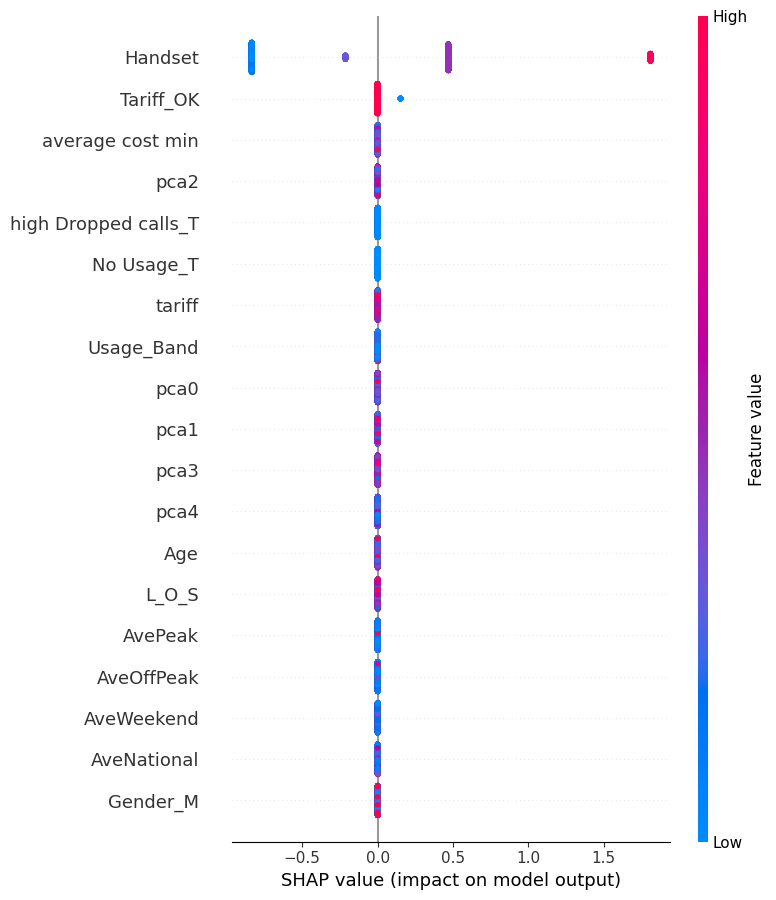

In [176]:
# Initialize the explainer using the best model
explainer = shap.Explainer(best_lgb_model)

# Calculate SHAP values using the best model
shap_values = explainer.shap_values(X_train_preprocessed)

# Visualize SHAP values
shap.summary_plot(shap_values, X_train_preprocessed)